<a href="https://colab.research.google.com/github/chandrakanta-chaudhury/Audio_signals_Research/blob/master/U_net_denoise_signals_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from scipy.io import wavfile
import scipy.io
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

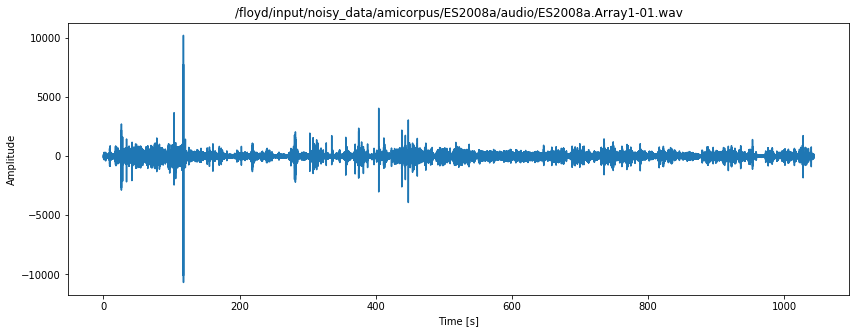

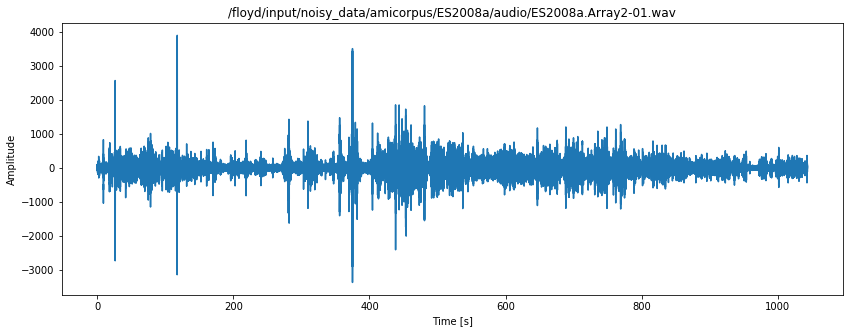

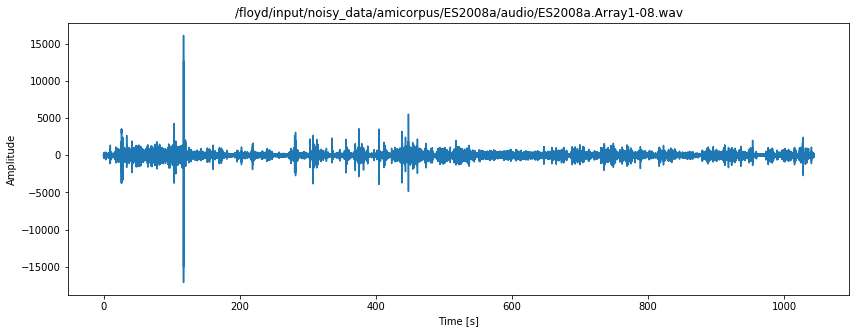

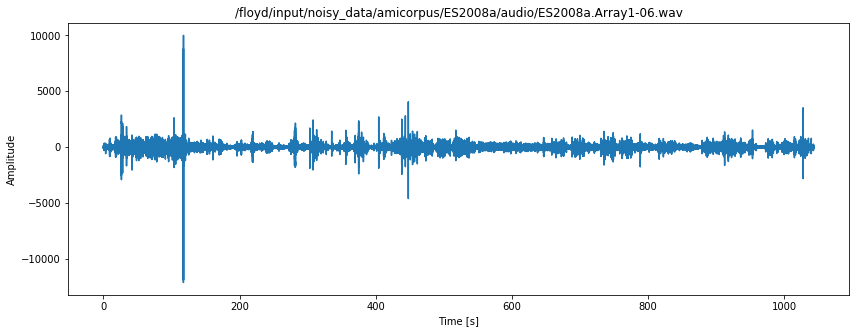

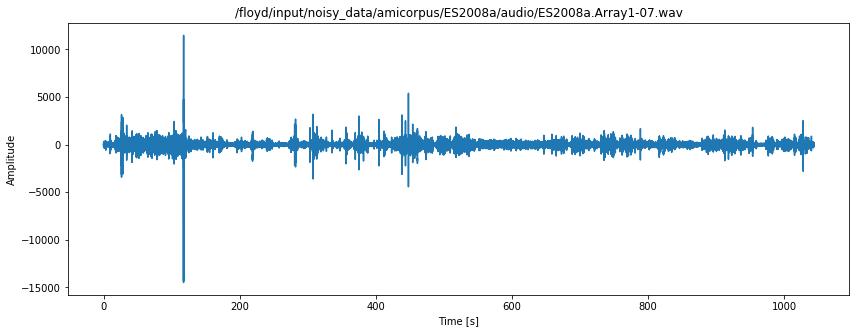

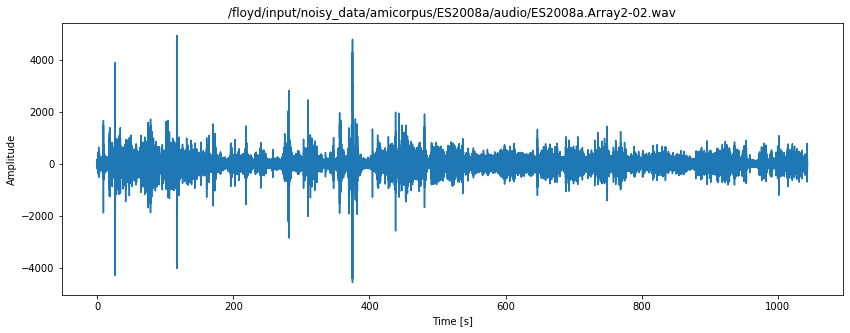

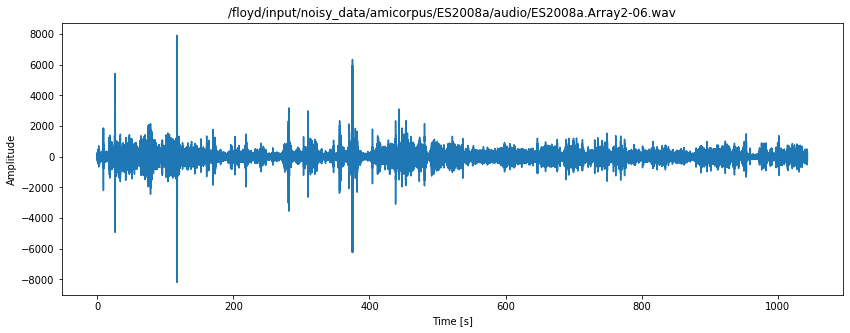

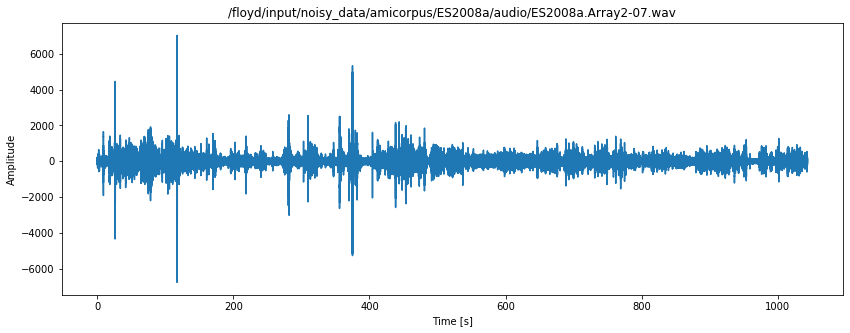

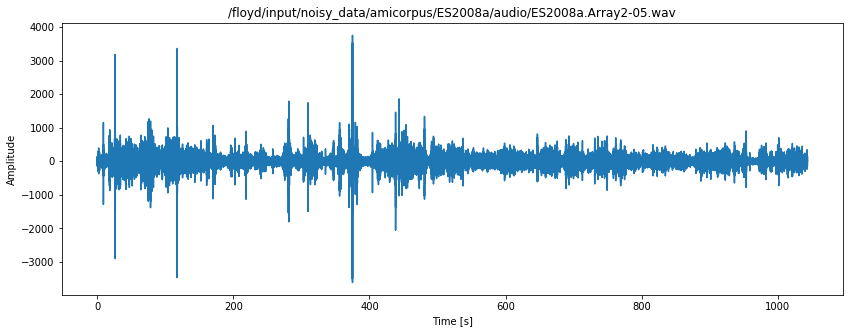

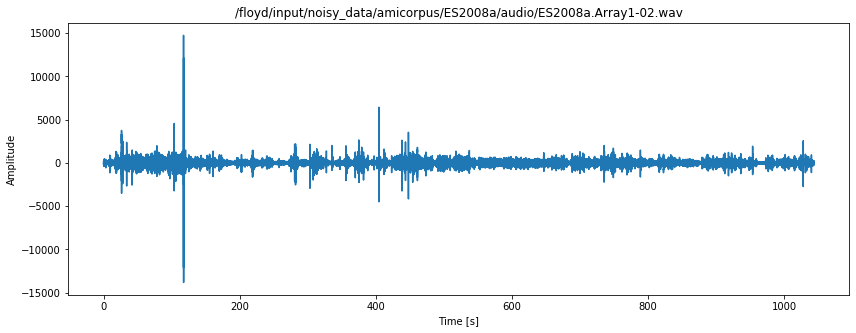

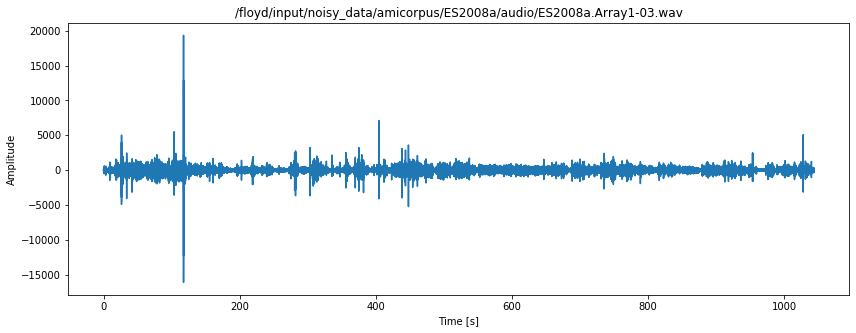

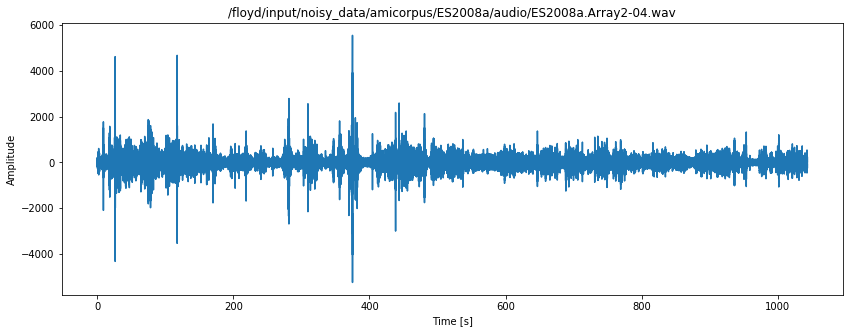

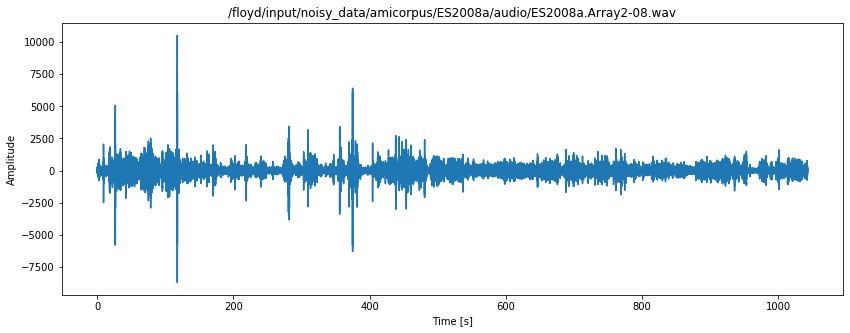

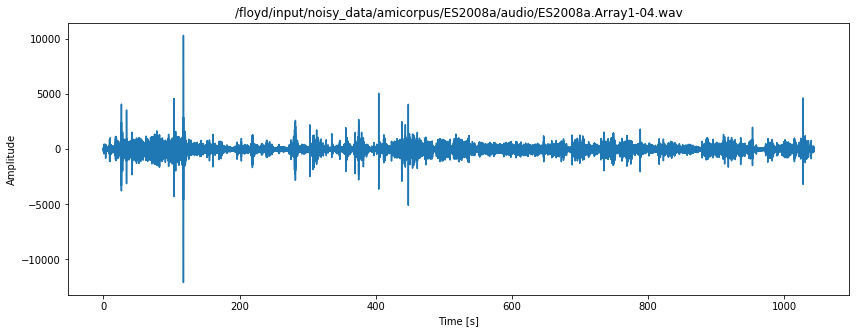

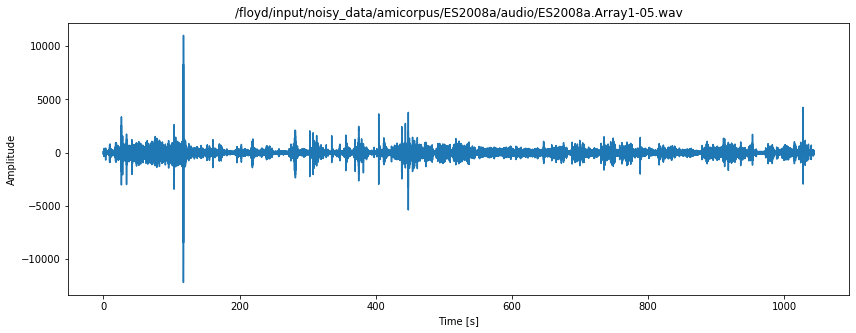

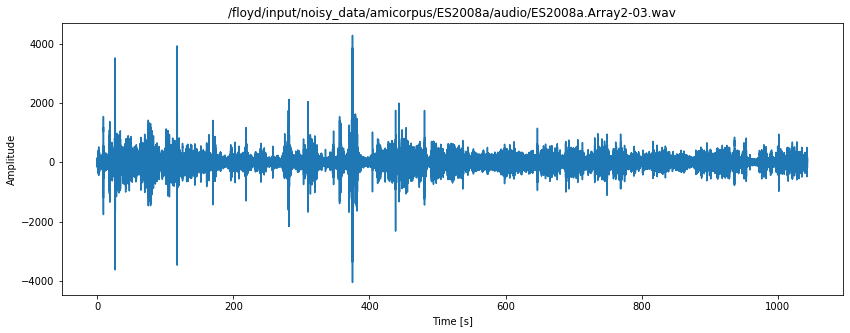

In [ ]:
for fname in glob("/floyd/input/noisy_data/amicorpus/ES2008a/audio/ES*.wav"):
  sr,x = wavfile.read(fname)
  plt.figure(figsize=(14, 5))
  duration = len(x)/sr
  time = np.arange(0,duration,1/sr)
  plt.plot(time,x)
  plt.xlabel('Time [s]')
  plt.ylabel('Amplitude')
  plt.title(fname)
  plt.show()

In [1]:
  import librosa
 # x , sr = librosa.load(fname)


In [5]:
import matplotlib.pyplot as plt
X_org = []
pad = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i - a.shape[0])))
for fname in glob("/content/drive/My Drive/amicorpus/ES2008a/audio/ES2008a.Array*.wav"):
  #sr,x = wavfile.read(fname)
  x , sr = librosa.load(fname)
  #print(fname)
  #print(len(x))
  padded = pad(x, 16384)
  X_org.append(padded)  

In [6]:
#Noise signals create
def get_white_noise(signal,SNR) :
    #RMS value of signal
    RMS_s=math.sqrt(np.mean(signal**2))
    #RMS values of noise
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/20)))
    #Additive white gausian noise. Thereore mean=0
    #Because sample length is large (typically > 40000)
    #we can use the population formula for standard daviation.
    #because mean=0 STD=RMS
    STD_n=RMS_n
    noise=np.random.normal(0, STD_n, signal.shape[0])
    return noise

In [7]:
import math
signal=np.interp(x, (x.min(), x.max()), (-1, 1))
noise=get_white_noise(signal,SNR=10)

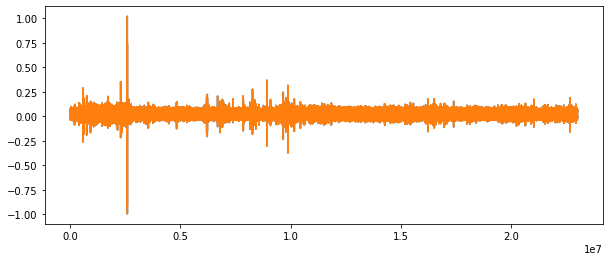

In [8]:
#After adding noise to audio signals this segment only to plot single noise , as it is crashing if plotting for all

X = []
pad = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i - a.shape[0])))
import matplotlib.pyplot as plt
for fname in glob("/content/drive/My Drive/amicorpus/ES2008a/audio/ES2008a.Array1-01.wav"):
  #sr,x = wavfile.read(fname)
  x , sr = librosa.load(fname)
  signal=np.interp(x, (x.min(), x.max()), (-1, 1))
  noise=get_white_noise(signal,SNR=10)
  signal_noise=signal+noise
  padded = pad(signal_noise, 16384)
  X.append(padded)
  fig, ax = plt.subplots(figsize=(10,4))
  ax.plot(signal_noise)
  plt.plot(signal_noise)

In [9]:
#run this to merge all signals  into single list 
X = []
pad = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i - a.shape[0])))
for fname in glob("/content/drive/My Drive/amicorpus/ES2008a/audio/ES2008a.Array*.wav"):
  sr,x = wavfile.read(fname)
  signal=np.interp(x, (x.min(), x.max()), (-1, 1))
  noise=get_white_noise(signal,SNR=10)
  signal_noise=signal+noise
  padded = pad(signal_noise, 16384)
  X.append(padded)

In [10]:
X=np.vstack(X)

In [11]:
X.shape

(12, 16384)

In [12]:
X_org=np.vstack(X_org)

In [13]:
X_org.shape

(12, 16384)

In [14]:
#split into train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(X,X_org,test_size=0.2)

In [15]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(9, 16384) (3, 16384) (9, 16384) (3, 16384)


In [16]:
#reshape
X_train=X_train.reshape(128,128,9)
y_train=y_train.reshape(128,128,9)
X_test=X_test.reshape(128,128,3)
y_test=y_test.reshape(128,128,3)

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
import tensorflow as tf

In [18]:
##resahping it again to avoid dimensional error
X_train = X_train.reshape(9,128,128,1)
y_train=y_train.reshape(9,128,128,1)
X_test=X_test.reshape(3,128,128,1)
y_test=y_test.reshape(3,128,128,1)

In [21]:
    input_size = (128,128,1)
    size_filter_in = 16
    #normal initialization of weights
    kernel_init = 'he_normal'
    #To apply leaky relu after the conv layer 
    activation_layer = None
    inputs = Input(input_size)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(inputs)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv1)
    conv1 = LeakyReLU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool1)
    conv2 = LeakyReLU()(conv2)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv2)
    conv2 = LeakyReLU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool2)
    conv3 = LeakyReLU()(conv3)
    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv3)
    conv3 = LeakyReLU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool3)
    conv4 = LeakyReLU()(conv4)
    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv4)
    conv4 = LeakyReLU()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool4)
    conv5 = LeakyReLU()(conv5)
    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv5)
    conv5 = LeakyReLU()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(size_filter_in*8, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(drop5))
    up6 = LeakyReLU()(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge6)
    conv6 = LeakyReLU()(conv6)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv6)
    conv6 = LeakyReLU()(conv6)
    up7 = Conv2D(size_filter_in*4, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv6))
    up7 = LeakyReLU()(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge7)
    conv7 = LeakyReLU()(conv7)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv7)
    conv7 = LeakyReLU()(conv7)
    up8 = Conv2D(size_filter_in*2, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv7))
    up8 = LeakyReLU()(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge8)
    conv8 = LeakyReLU()(conv8)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv8)
    conv8 = LeakyReLU()(conv8)

    up9 = Conv2D(size_filter_in, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv8))
    up9 = LeakyReLU()(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)
    conv10 = Conv2D(1, 1, activation = 'tanh')(conv9)
   

In [22]:
 model = Model(inputs,conv10)

In [23]:
model.compile(optimizer = 'adam', loss = tf.keras.losses.Huber(), metrics = ['mae'])
#from tensorflow.keras.optimizers import SGD
#sgd=SGD(learning_rate=0.0001, momentum=0.0, nesterov=False)
#model.compile(optimizer = sgd, loss = tf.keras.losses.Huber(), metrics = ['mae'])

In [24]:
model.fit(X_train,y_train,
              epochs=50,
              batch_size=1,
             shuffle=True,
            validation_data=(X_test,y_test))

Epoch 1/50
9/9 [==============================] - 3s 328ms/step - loss: 0.0019 - mae: 0.0371 - val_loss: 9.8099e-05 - val_mae: 0.0105
Epoch 2/50
9/9 [==============================] - 2s 264ms/step - loss: 1.1779e-04 - mae: 0.0115 - val_loss: 9.2091e-05 - val_mae: 0.0104
Epoch 3/50
9/9 [==============================] - 2s 265ms/step - loss: 2.3556e-04 - mae: 0.0156 - val_loss: 1.5662e-04 - val_mae: 0.0128
Epoch 4/50
9/9 [==============================] - 3s 292ms/step - loss: 5.1114e-04 - mae: 0.0233 - val_loss: 2.1439e-04 - val_mae: 0.0171
Epoch 5/50
9/9 [==============================] - 2s 266ms/step - loss: 3.0808e-04 - mae: 0.0194 - val_loss: 4.5912e-04 - val_mae: 0.0268
Epoch 6/50
9/9 [==============================] - 2s 267ms/step - loss: 3.4510e-04 - mae: 0.0201 - val_loss: 8.8473e-05 - val_mae: 0.0111
Epoch 7/50
9/9 [==============================] - 2s 271ms/step - loss: 3.0471e-05 - mae: 0.0058 - val_loss: 9.2377e-05 - val_mae: 0.0113
Epoch 8/50
9/9 [======================

In [25]:
y=model.predict(X_test)

In [26]:
y.shape

(3, 128, 128, 1)

In [27]:
y=y.reshape(16384,3)

In [34]:
#check for one sample signal
y2=y[:,1]

In [35]:
y2.shape

(16384,)

In [36]:
#write it to check signal
 librosa.output.write_wav("test001.wav",y2,sr=sr)

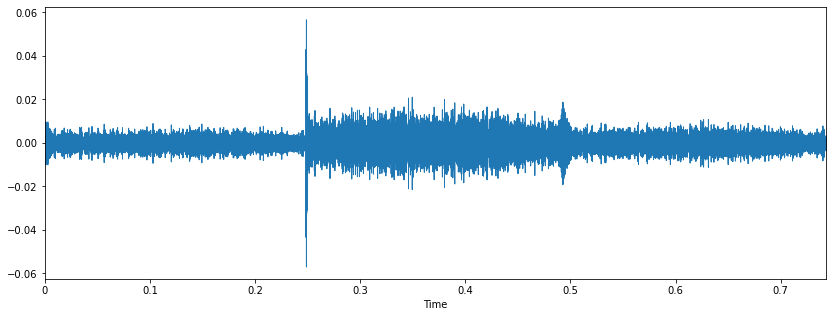

In [39]:
import librosa
fname="/content/test001.wav"
x , sr = librosa.load(fname)
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x,sr=sr)